In [33]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [34]:
# 读取csv数据
fio_Raw_data = pd.read_csv("fio_Raw_data.csv")
linpack_Raw_data = pd.read_csv("linpack_Raw_data.csv")
mlc_Raw_data = pd.read_csv("mlc_Raw_data.csv")
tpc_Raw_data = pd.read_csv("tpc_Raw_data.csv")

# 第一列有序号的去掉
fio_Raw_data = fio_Raw_data.drop(columns=fio_Raw_data.columns[0])
mlc_Raw_data = mlc_Raw_data.drop(columns=mlc_Raw_data.columns[0])
tpc_Raw_data = tpc_Raw_data.drop(columns=tpc_Raw_data.columns[0])

In [35]:
# 数据清洗 
raw_data_list = [fio_Raw_data,linpack_Raw_data,mlc_Raw_data,tpc_Raw_data]
clean_data_list = []
for raw_data in raw_data_list:
    clean_data = raw_data
    for col in raw_data.columns:
        if col != 'species':
            mean = raw_data[col].mean()
            std = raw_data[col].std()
            low = mean - 3 * std
            high = mean + 3 * std
            # 偏离3倍sigma的不要
            clean_data = clean_data.loc[(clean_data[col] > low) & (clean_data[col] < high), :]
    clean_data_list.append(clean_data)

In [36]:
# 合并数据
merge_clean_data = pd.concat(clean_data_list, ignore_index=True)
# 这个是不带species的数据，为了求相关性矩阵
merge_clean_data_without_species = merge_clean_data.drop(columns='species')

In [37]:
correlated_matrix = merge_clean_data_without_species.corr()

In [38]:
correlated_matrix

,Average1,Average5,TasksTotal,TasksRuning,TasksSleeping,CpuUs,CpuSy,CpuId,MemFree,MemUsed,MemBuff,SwapAvail,DiskRead,DiskWrite,NetRead,NetWrite,SysInt,SysCsw
Average1,1.000000,0.911872,0.429684,0.371210,0.396497,0.514041,-0.493832,-0.538045,-0.453520,0.479096,-0.700482,-0.478657,0.110105,-0.839856,0.095150,-0.044614,-0.811683,-0.833103
Average5,0.911872,1.000000,0.503196,0.459119,0.465547,0.383302,-0.397152,-0.404280,-0.525564,0.552894,-0.758766,-0.552417,0.134944,-0.915832,0.073833,-0.062235,-0.897235,-0.915390
TasksTotal,0.429684,0.503196,1.000000,0.946160,0.997756,0.120140,-0.049137,0.030509,-0.998554,0.996972,-0.213667,-0.997021,-0.285016,-0.343318,0.087950,-0.049590,-0.315062,-0.342848
TasksRuning,0.371210,0.459119,0.946160,1.000000,0.945778,0.102207,0.018823,0.061481,-0.942937,0.940164,-0.172420,-0.940246,-0.324956,-0.297954,0.089081,-0.038255,-0.269737,-0.297761
TasksSleeping,0.396497,0.465547,0.997756,0.945778,1.000000,0.129210,-0.012518,0.041169,-0.994823,0.990996,-0.161221,-0.991096,-0.342035,-0.291236,0.085414,-0.044640,-0.261140,-0.290571
CpuUs,0.514041,0.383302,0.120140,0.102207,0.129210,1.000000,-0.196307,-0.925541,-0.149519,0.155332,-0.170770,-0.155345,-0.366999,-0.272256,0.024790,0.034228,-0.232975,-0.260758
CpuSy,-0.493832,-0.397152,-0.049137,0.018823,-0.012518,-0.196307,1.000000,0.340199,0.073781,-0.092666,0.451879,0.092238,-0.483126,0.473210,-0.035951,0.036491,0.491871,0.484021
CpuId,-0.538045,-0.404280,0.030509,0.061481,0.041169,-0.925541,0.340199,1.000000,0.007468,-0.022171,0.339266,0.021956,0.012133,0.399389,-0.012075,-0.016978,0.377602,0.389621
MemFree,-0.453520,-0.525564,-0.998554,-0.942937,-0.994823,-0.149519,0.073781,0.007468,1.000000,-0.999100,0.229690,0.999134,0.267872,0.367793,-0.086126,0.051273,0.343214,0.370669
MemUsed,0.479096,0.552894,0.996972,0.940164,0.990996,0.155332,-0.092666,-0.022171,-0.999100,1.000000,-0.270758,-1.000000,-0.242830,-0.403462,0.088954,-0.053337,-0.375907,-0.402937


[]

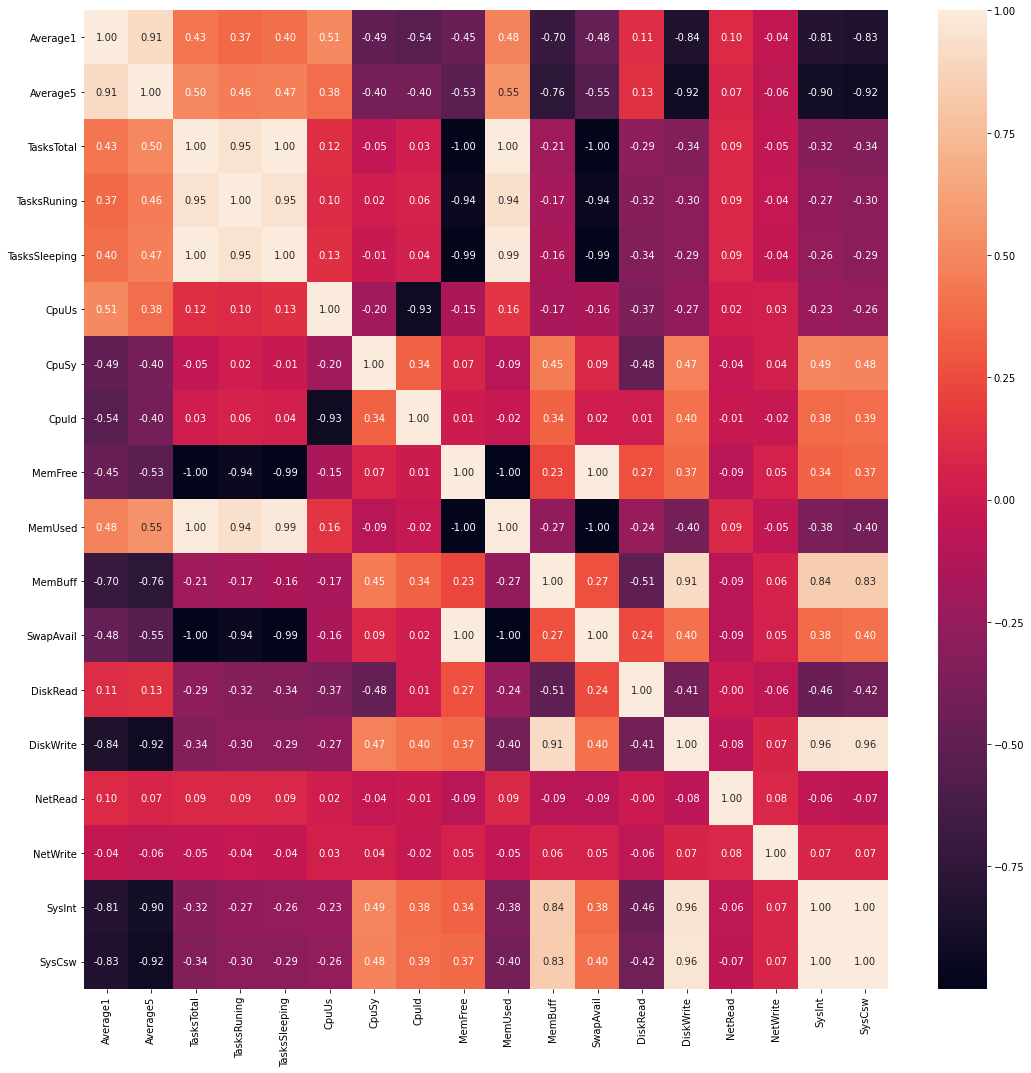

In [39]:
# 画热力图
pic = plt.figure(figsize=(18,18))
pic = sb.heatmap(correlated_params,annot=True,fmt='.2f')
plt.plot()

In [53]:
# 剔除特征
merge_final_data = merge_clean_data_without_species.drop(columns=['MemFree','MemUsed','TasksRuning','TasksSleeping','SwapAvail','SysCsw'])
# 标准化
merge_final_data = (merge_final_data - merge_final_data.mean()) / merge_final_data.std()
# 把species加上
merge_final_data['species'] = merge_clean_data['species']

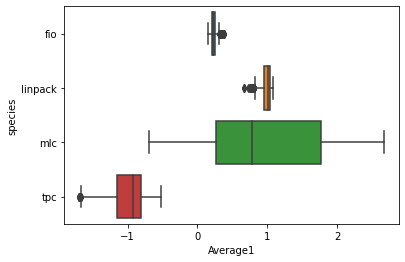

In [54]:
# 箱型图
sb.boxplot(x=merge_final_data['Average1'],y=merge_final_data['species'])

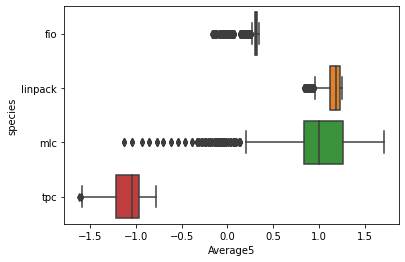

In [55]:
sb.boxplot(x=merge_final_data['Average5'],y=merge_final_data['species'])

In [56]:
# 划分数据集
fio_data = merge_final_data.loc[merge_final_data['species']=='fio']
linpack_data = merge_final_data.loc[merge_final_data['species']=='linpack']
mlc_data = merge_final_data.loc[merge_final_data['species']=='mlc']
tpc_data = merge_final_data.loc[merge_final_data['species']=='tpc']

# 8：2划分
fio_train = fio_data.sample(frac=0.8)
fio_test = fio_data[~fio_data.index.isin(fio_train.index)]

linpack_train = linpack_data.sample(frac=0.8)
linpack_test = linpack_data[~linpack_data.index.isin(linpack_train.index)]

mlc_train = mlc_data.sample(frac=0.8)
mlc_test = mlc_data[~mlc_data.index.isin(mlc_train.index)]

tpc_train = tpc_data.sample(frac=0.8)
tpc_test = tpc_data[~tpc_data.index.isin(tpc_train.index)]

In [57]:
# 再把所有数据集合起来
train_set = pd.concat([fio_train,linpack_train,mlc_train,tpc_train])
test_set = pd.concat([fio_test,linpack_test,mlc_test,tpc_test])

In [58]:
# 保存数据为csv
train_set.to_csv('train.csv')
test_set.to_csv('test.csv')


In [62]:
# 读数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_set = train.drop(columns=['Unnamed: 0','species'],axis=1)
train_labels = train['species']
labels = ['fio','linpack','mlc','tpc']
test_set = test.drop(columns=['Unnamed: 0','species'],axis=1)
test_labels = test['species']


In [63]:
# 没用one-hot，后面用softmax分类，这里是把label变成数字
train_labels = train_labels.replace('fio',0).replace('linpack',1).replace('mlc',2).replace('tpc',3).values
test_labels = test_labels.replace('fio',0).replace('linpack',1).replace('mlc',2).replace('tpc',3).values

In [64]:
# 全连接的NN，20个hidden nodes，4个output nodes
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])

In [65]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.01), # 梯度下降
    loss='sparse_categorical_crossentropy', # 交叉熵loss
    metrics=['accuracy']
)

In [66]:
# 训练
model.fit(train_set,train_labels,epochs=5)

Epoch 1/5
325/325 [==============================] - 1s 1ms/step - loss: 0.8065 - accuracy: 0.7708
Epoch 2/5
325/325 [==============================] - 0s 1ms/step - loss: 0.1218 - accuracy: 0.9955
Epoch 3/5
325/325 [==============================] - 0s 1ms/step - loss: 0.0569 - accuracy: 0.9984
Epoch 4/5
325/325 [==============================] - 0s 1ms/step - loss: 0.0338 - accuracy: 0.9994
Epoch 5/5
325/325 [==============================] - 0s 994us/step - loss: 0.0234 - accuracy: 0.9988


In [67]:
results = model.predict(test_set)
prediction = np.argmax(results,axis=1)

In [68]:
cm = confusion_matrix(prediction,test_labels,labels=range(4))
print(cm)

[[ 500    0    0    0]
 [   0  449    0    0]
 [   3    0  553    0]
 [   0    0    0 1094]]
